In [1]:
"""LinearEncoderDecoderMNIST.ipynb"""

# Mount Google Drive and copy necessary files
from google.colab import drive
drive.mount('/content/drive')
!cp drive/MyDrive/helpers.py .

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import torch
import numpy as np
from torchvision import datasets
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from tqdm import tqdm
from helpers import get_data_loaders, seed_all, anomaly_detection_display
import pandas as pd
import matplotlib.pyplot as plt

# Get data loaders for the MNIST dataset for train, validation, and test dataset
data_loaders = get_data_loaders(batch_size=1024)

# Set the device to CUDA if available, otherwise CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Using 48000 examples for training and 12000 for validation
Using 10000 for testing


In [3]:
class Autoencoder(nn.Module):
    def __init__(self, encoding_dim):
        """
        Initializes the Autoencoder model.

        Parameters:
        - encoding_dim (int): The size of the encoding dimension. This is the compressed representation size.

        The model consists of two main parts: the encoder and the decoder.
        The encoder compresses the input image into a lower-dimensional encoding.
        The decoder reconstructs the image from this encoding.
        """
        super(Autoencoder, self).__init__()

        ## encoder ##
        # The encoder is a sequential neural network that gradually compresses
        # the input image into a smaller representation defined by `encoding_dim`.
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 256),  # Flatten the input and reduce to 256 features
            nn.ReLU(),  # Activation function to introduce non-linearity
            nn.BatchNorm1d(256),  # Normalize the activations of the first layer
            nn.Linear(256, 128),  # Further reduce features to 128
            nn.ReLU(),  # Activation function
            nn.BatchNorm1d(128),  # Normalize the activations of the second layer
            nn.Linear(128, encoding_dim)  # Final compression to the encoding dimension
        )

        ## decoder ##
        # The decoder is a sequential neural network that reconstructs the image
        # from its encoded representation back to its original dimension.
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, 128),  # Expand the encoding to 128 features
            nn.ReLU(),  # Activation function
            nn.BatchNorm1d(128),  # Normalize the activations
            nn.Linear(128, 256),  # Further expand features to 256
            nn.ReLU(),  # Activation function
            nn.BatchNorm1d(256),  # Normalize the activations
            nn.Linear(256, 28*28),  # Expand back to the original image size
            nn.Sigmoid()  # Sigmoid activation to ensure output values between 0 and 1
        )

    def forward(self, x):
        """
        Defines the forward pass of the autoencoder.

        Parameters:
        - x (Tensor): The input tensor containing the images.

        Returns:
        - Tensor: The reconstructed images as a tensor.
        """
        x = x.view(-1, 28*28)  # Flatten the input image into a vector
        encoded = self.encoder(x)  # Compress the image using the encoder
        decoded = self.decoder(encoded)  # Reconstruct the image from its encoding
        return decoded.view((x.shape[0], 1, 28, 28))  # Reshape the output back to the original image shape


In [4]:
# Initialize the autoencoder model
encoding_dim = 32  # Set the dimensionality of the encoding space.
model = Autoencoder(encoding_dim).to(device)  # Create an Autoencoder instance and move it to the current device (GPU or CPU).

# Define the loss function and the optimizer
criterion = nn.MSELoss()  # Use Mean Squared Error Loss as the criterion for measuring the difference between the original and reconstructed images.
optimizer = torch.optim.Adam(model.parameters(), lr=5e-2)  # Use the Adam optimizer for adjusting model weights, with a learning rate of 0.05.

# Set the number of training epochs
n_epochs = 25  # Defines how many times the entire dataset will pass through the network during training.

# Initialize lists to store loss values for each epoch
epoch_train_losses = []
epoch_val_losses = []


In [5]:
# Training loop
for epoch in range(1, n_epochs + 1):  # Iterate over the specified number of epochs.
    train_loss = 0.0  # Initialize the training loss for the epoch.
    model.train()  # Set the model to training mode (this affects layers like dropout, batchnorm, etc.)

    # Iterate over the training dataset
    for data in tqdm(data_loaders['train'], desc="Training", leave=False):  # Use tqdm to display a progress bar
        images, _ = data  # Unpack the data. Labels are ignored because it's an autoencoder.
        images = images.to(device)  # Move the images to the configured device (GPU or CPU).

        optimizer.zero_grad()  # Clear previous gradients.
        outputs = model(images)  # Forward pass: compute predicted images by passing inputs to the model.
        loss = criterion(outputs, images)  # Calculate the loss between the predicted and actual images.
        loss.backward()  # Backward pass: compute gradient of the loss with respect to model parameters.
        optimizer.step()  # Perform a single optimization step (parameter update).
        train_loss += loss.item() * images.size(0)  # Update the training loss for the batch.

    # Validation phase
    val_loss = 0.0  # Initialize the validation loss for the epoch.
    model.eval()  # Set the model to evaluation mode.
    with torch.no_grad():  # Disable gradient calculation.
        # Iterate over the validation dataset
        for data in tqdm(data_loaders['valid'], desc="Validating", leave=False):  # Again, use tqdm for a progress bar.
            images, _ = data  # Unpack the data, ignoring labels.
            images = images.to(device)  # Move the images to the device.
            outputs = model(images)  # Compute the model output.
            loss = criterion(outputs, images)  # Calculate the loss.
            val_loss += loss.item() * images.size(0)  # Update the validation loss for the batch.

    # Calculate the average losses for this epoch
    train_loss /= len(data_loaders['train'].dataset)  # Average training loss for the epoch.
    val_loss /= len(data_loaders['valid'].dataset)  # Average validation loss for the epoch.

    # Append the average losses to their respective lists
    epoch_train_losses.append(train_loss)
    epoch_val_losses.append(val_loss)

    # Print the training and validation losses
    print(f"Epoch: {epoch} \tTraining Loss: {train_loss:.6f}\tValid Loss: {val_loss:.6f}")


Epoch: 1 	Training Loss: 0.065293	Valid Loss: 0.052090


Epoch: 2 	Training Loss: 0.036166	Valid Loss: 0.032505


Epoch: 3 	Training Loss: 0.029296	Valid Loss: 0.050642


Epoch: 4 	Training Loss: 0.025907	Valid Loss: 0.025097


Epoch: 5 	Training Loss: 0.023391	Valid Loss: 0.023394


Epoch: 6 	Training Loss: 0.021676	Valid Loss: 0.021956


Epoch: 7 	Training Loss: 0.019968	Valid Loss: 0.019692


Epoch: 8 	Training Loss: 0.018439	Valid Loss: 0.018387


Epoch: 9 	Training Loss: 0.017285	Valid Loss: 0.027050


Epoch: 10 	Training Loss: 0.019627	Valid Loss: 0.019233


Epoch: 11 	Training Loss: 0.016311	Valid Loss: 0.016243


Epoch: 12 	Training Loss: 0.015578	Valid Loss: 0.015880


Epoch: 13 	Training Loss: 0.015025	Valid Loss: 0.015287


Epoch: 14 	Training Loss: 0.014244	Valid Loss: 0.015775


Epoch: 15 	Training Loss: 0.013496	Valid Loss: 0.013304


Epoch: 16 	Training Loss: 0.013050	Valid Loss: 0.013714


Epoch: 17 	Training Loss: 0.012579	Valid Loss: 0.012847


Epoch: 18 	Training Loss: 0.012100	Valid Loss: 0.012369


Epoch: 19 	Training Loss: 0.011774	Valid Loss: 0.011948


Epoch: 20 	Training Loss: 0.011567	Valid Loss: 0.012020


Epoch: 21 	Training Loss: 0.011219	Valid Loss: 0.011499


Epoch: 22 	Training Loss: 0.010964	Valid Loss: 0.011150


Epoch: 23 	Training Loss: 0.010720	Valid Loss: 0.011079


Epoch: 24 	Training Loss: 0.010312	Valid Loss: 0.010481


Epoch: 25 	Training Loss: 0.010299	Valid Loss: 0.010282


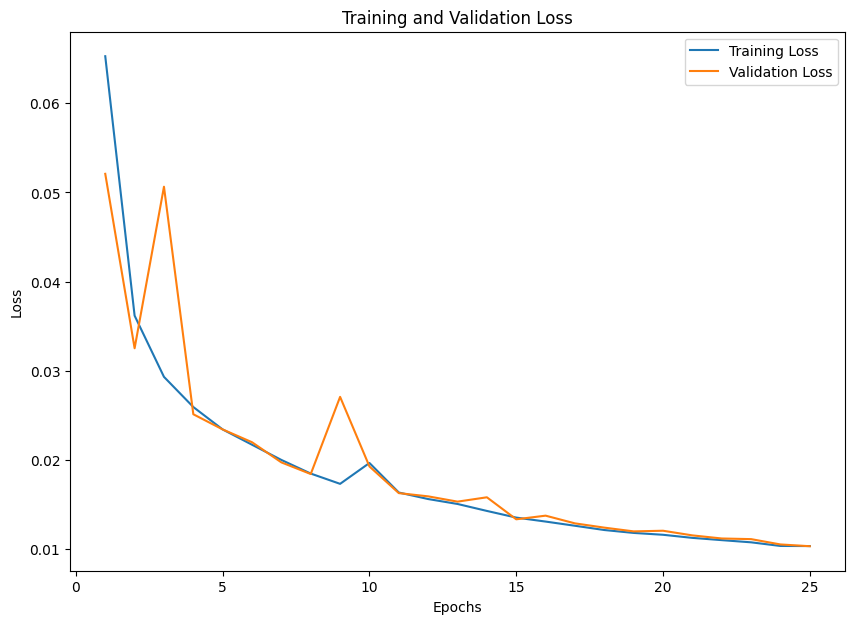

In [6]:
# Plotting the training and validation loss curves
plt.figure(figsize=(10, 7))  # Create a new figure with specified figure size
plt.plot(range(1, n_epochs + 1), epoch_train_losses, label='Training Loss')
plt.plot(range(1, n_epochs + 1), epoch_val_losses, label='Validation Loss')


# Setting the label for the x-axis.
plt.xlabel('Epochs')  # Label the x-axis as "Epochs"
# Setting the label for the y-axis.
plt.ylabel('Loss')  # Label the y-axis as "Loss"

# Adding a legend to differentiate between training and validation loss lines
plt.legend()  # Show a legend to label the training and validation lines

# Adding a title to the plot
plt.title('Training and Validation Loss')  # Set the title of the plot

# Display the plot
plt.show()  # Render the plot so it's visible


Testing: 100%|██████████| 10/10 [00:01<00:00,  5.51it/s]


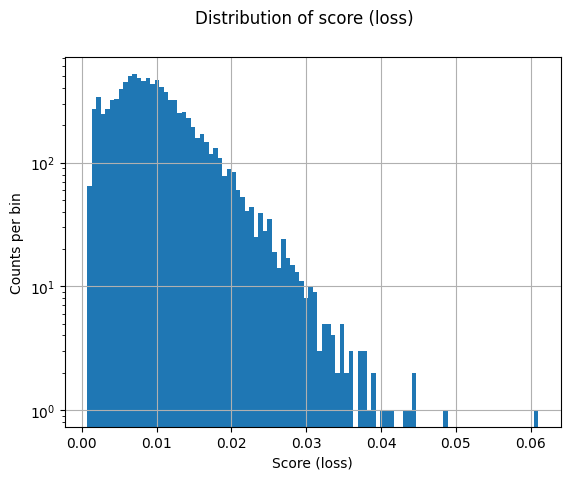

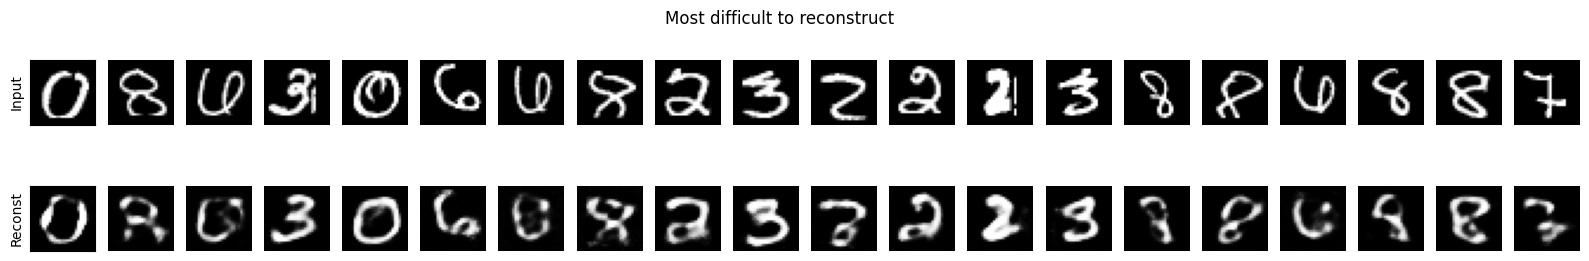

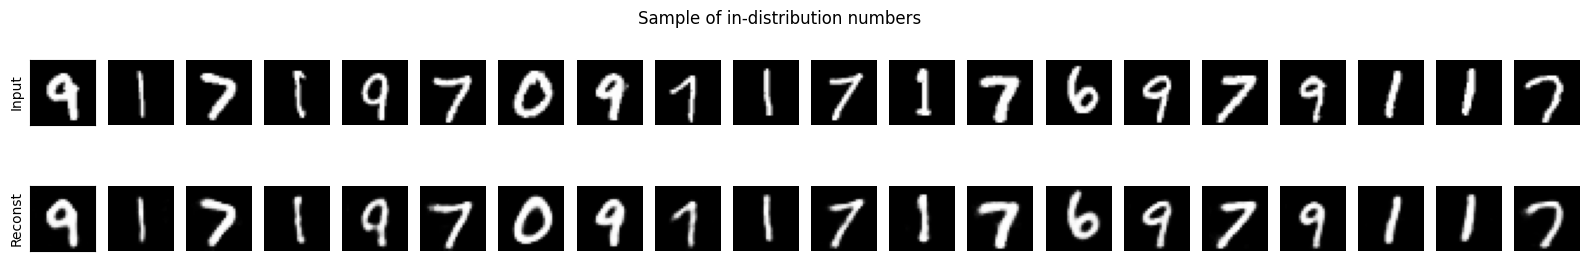

In [7]:
# Testing loop to evaluate the model
losses = {}  # Dictionary to store losses and reconstructed images for each test sample.
loss_no_reduction = nn.MSELoss(reduction='none')  # Use a version of the loss function that does not reduce the batch losses to a single value.

idx = 0  # Initialize an index counter to keep track of the current sample index across batches.

with torch.no_grad():  # Disable gradient calculation to save memory and computations.
    for data in tqdm(desc="Testing", total=len(data_loaders['test']), iterable=data_loaders['test']):  # Iterate over the test dataset.
        images, _ = data  # Unpack the data, ignoring the labels since they're not needed for reconstruction.
        images = images.to(device)  # Move the images to the current device (GPU or CPU).
        outputs = model(images)  # Forward pass: compute the reconstructed images.
        loss = loss_no_reduction(outputs, images)  # Compute the loss for each image in the batch without reduction.

        # Prepare the images and outputs for storage by moving them to CPU if necessary.
        if torch.cuda.is_available():
            images = images.cpu()
            outputs = outputs.cpu()

        # Accumulate the losses and images for analysis.
        for i, l in enumerate(loss.mean(dim=[1, 2, 3])):  # Calculate the mean loss per image.
            losses[idx + i] = {  # Store the per-image loss and the original and reconstructed images in the dictionary.
                'loss': float(l.cpu().numpy()),  # Store the loss as a float.
                'image': images[i].numpy(),  # Convert the tensor to a NumPy array for the original image.
                'reconstructed': outputs[i].numpy()  # Convert the tensor to a NumPy array for the reconstructed image.
            }

        idx += loss.shape[0]  # Update the index counter by the number of images in the current batch.

# Store results in a pandas DataFrame
df = pd.DataFrame(losses).T  # Transpose the dictionary to a DataFrame for easier analysis.

# Display anomaly detection results
anomaly_detection_display(df)  # Call a function to display the results, potentially identifying anomalies based on reconstruction loss.
